# Machine Learning for the classification of sampled networks

In the following section, a Machine Learning task is implemented to answer the following questions: Can a ML model differentiate between different samples only by its network metrics? If so, which metrics contribute the momst for teh differentiation? 

In other words, a sample obtained by teh SB method is different, topologically, from a network obtained using RWS method? Such difference can be learned by an ML model?

Here we use the ``catboost`` model to classify sampled networks by their sampling method and use SHAP values to obtain the impact of each variable in the classification.
 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random as rd
import math
import altair as alt

from scipy.stats import entropy
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
import catboost
import shap
import sklearn

In [4]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer, roc_auc_score

The model performance metric chosen for this task was the Gini coefficient, which can be obtained from the AUC metric (Area Under the Curve) of the ROC (Receiver Operating Characteristics):

$$G = (|AUC|-0.5)\cdot 2$$

This is a well known metric for binary classification problems.

In [5]:
def gini_score(expected, predicted, **unused_kwargs) -> float:
    return abs(roc_auc_score(expected, predicted)-0.5)*2.0

Loading the data from the sample generation notebooks in the ``2-multivariave-analysis`` folder:

In [6]:
data_ba = pd.read_csv('2_multivariate_analysis/data/pca_ba_robust_example.csv')
data_ba['type'] = 'BA'

data_er = pd.read_csv('2_multivariate_analysis/data/pca_er_robust_example2.csv')
data_er['type'] = 'ER'

data_sw = pd.read_csv('2_multivariate_analysis/data/pca_sw_robust_example.csv')
data_sw['type'] = 'SW'

data_maier = pd.read_csv('2_multivariate_analysis/data/pca_meier_robust_example.csv')
data_maier['type'] = 'Maier'

Concatenating the daraftames into a single one:

In [7]:
data_base = pd.concat([data_ba, data_er, data_sw, data_maier], axis=0)

The analysis proposed here is composed of iterative steps. Let us consider, for example, one of the twelve test groups mentioned earlier: the BA network samples with size B=30. First, this set is filtered for RWS and MHRW samples, which are the techniques of interest in one of the proposed classification tasks. At each iterative step, three sets are obtained from this data. First, a test set comprising 40% of the base size, being a simple random sample without replacement from the original set. Then, two other sets, the training set and the validation set, are obtained from the remaining 60%, with the former representing 80% of this set and the latter 20%. These two sets are disjoint. Then, the training and validation sets are used in the machine learning task of training a ``CatBoost`` model. This model is used to obtain the performance through the Gini metric on the test set (which refers to samples of BA networks, B=30) and the Gini in one of the remaining eleven base sets (which refer to all other combinations of network type sampled and sample size that are not BA, B=30). The first Gini calculated here is called the training Gini and the second, the test Gini. This procedure is repeated eleven times, until all the base sets not involved in the model training are used for testing. Thus, the procedure ends with eleven test Gini metrics and eleven training Gini metrics, and the mean $\mu^2$​ and variance $\sigma^2$ are calculated for each case. The same approach is used to train a model to differentiate RWS and SB samples and to differentiate TR and SB samples.

All possible combinations of test and trainning sets are obteined bellow:

In [8]:
import itertools

combinations_list = list(itertools.product(['BA', 'ER', 'SW', 'Maier'], [30,75,120]))

In [9]:
simulations = []

In [10]:
for method_train, size_train in combinations_list:
    
    train = {'types': [method_train],
             'sizes': [size_train]}
    
    for method_test, size_test in combinations_list:
        
        if method_train == method_test and size_train == size_test:
            continue
        
        test  = {'types': [method_test],
                 'sizes': [size_test]}
        
        simulation = {'train': train,
                      'test': test}

        simulations.append(simulation)

The following function performs the approach explained earlier, training a catboost model in each iteration end returning the results. It receives the data, the methods to be compared and returns the retults for each learning task step.

In [11]:
def simulator(data, simulations, method0, method1):
    
    # simulator init 
    
    simulation_results = []
    
    counter = 0
    total = len(simulations)
    
    for simulation in simulations:
        
        
        train = simulation['train']
        test = simulation['test']
    
        train_data = data[(data['type'].isin(train['types'])) & (data['len'].isin(train['sizes']))]
        test_data = data[(data['type'].isin(test['types'])) & (data['len'].isin(test['sizes']))]

        subpop_data = train_data[(train_data['method']==method1) | (train_data['method']==method0)].copy()
        
        subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

        # X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
        # X = subpop_data[['Component0', 'Component1', 'Component2']]
        X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator', 'type'], axis=1)
        y = subpop_data['indicator']

        X_train_superset, X_test, y_train_superset, y_test = train_test_split(X, y, test_size=0.4)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_superset, y_train_superset, test_size=0.2)

        del X_train_superset
        del y_train_superset

        train_pool = Pool(X_train, y_train)
        
        model = CatBoostClassifier(
            thread_count=3,
            iterations=1000,
            learning_rate=.015,
            depth=5.0,
            l2_leaf_reg=0.550,
            min_child_samples=10.0,
            grow_policy='SymmetricTree',
            loss_function='Logloss',
            eval_metric='Logloss',
            od_type='Iter',
            bootstrap_type='Bayesian',
            auto_class_weights='Balanced',
            
            silent=True
        ).fit(
            train_pool,
            early_stopping_rounds=100,
            eval_set=Pool(X_valid, y_valid),
            save_snapshot=False
        )

        y_pred = np.round(model.predict_proba(X_test)[:, 1], 5)    
        # print('\n\ntrain: ', gini_score(y_test, y_pred))
        
        train_gini = gini_score(y_test, y_pred)


        subpop_data = test_data[(test_data['method']==method1) | (test_data['method']==method0)].copy()
        
        subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

        # X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
        # X = subpop_data[['Component0', 'Component1', 'Component2']]
        X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator', 'type'], axis=1)
        y = subpop_data['indicator']

        y_pred = np.round(model.predict_proba(X)[:, 1], 5)
        # print('test: ', gini_score(y, y_pred))
        
        test_gini = gini_score(y, y_pred)
        
        
        result = {'train_type': train['types'][0],
                  'train_size': train['sizes'][0],
                  'test_type': test['types'][0],
                  'test_size': test['sizes'][0],
                  'train_gini': train_gini,
                  'test_gini': test_gini}
        
        simulation_results.append(result)
        
        del result
        del subpop_data
        del train_data
        del test_data
        
        counter = counter + 1
        
        print('\nCompleteness: ', np.round(counter/total, 2))
        
        
    return simulation_results

## RWS and MHRW classification task

In [12]:
results = simulator(data_base, simulations, method0='RWS', method1='MHRW')


Completeness:  0.01

Completeness:  0.02

Completeness:  0.02

Completeness:  0.03

Completeness:  0.04

Completeness:  0.05

Completeness:  0.05

Completeness:  0.06

Completeness:  0.07

Completeness:  0.08

Completeness:  0.08

Completeness:  0.09

Completeness:  0.1

Completeness:  0.11

Completeness:  0.11

Completeness:  0.12

Completeness:  0.13

Completeness:  0.14

Completeness:  0.14

Completeness:  0.15

Completeness:  0.16

Completeness:  0.17

Completeness:  0.17

Completeness:  0.18

Completeness:  0.19

Completeness:  0.2

Completeness:  0.2

Completeness:  0.21

Completeness:  0.22

Completeness:  0.23

Completeness:  0.23

Completeness:  0.24

Completeness:  0.25

Completeness:  0.26

Completeness:  0.27

Completeness:  0.27

Completeness:  0.28

Completeness:  0.29

Completeness:  0.3

Completeness:  0.3

Completeness:  0.31

Completeness:  0.32

Completeness:  0.33

Completeness:  0.33

Completeness:  0.34

Completeness:  0.35

Completeness:  0.36

Completeness:  0.

In [13]:
results1 = pd.DataFrame(results)

In [14]:
results1.to_csv('presentation_results/ml_mhrw_rws.csv', index=False)

## RWS and SB classification task

In [15]:
results = simulator(data_base, simulations, method0='RWS', method1='SB')


Completeness:  0.01

Completeness:  0.02

Completeness:  0.02

Completeness:  0.03

Completeness:  0.04

Completeness:  0.05

Completeness:  0.05

Completeness:  0.06

Completeness:  0.07

Completeness:  0.08

Completeness:  0.08

Completeness:  0.09

Completeness:  0.1

Completeness:  0.11

Completeness:  0.11

Completeness:  0.12

Completeness:  0.13

Completeness:  0.14

Completeness:  0.14

Completeness:  0.15

Completeness:  0.16

Completeness:  0.17

Completeness:  0.17

Completeness:  0.18

Completeness:  0.19

Completeness:  0.2

Completeness:  0.2

Completeness:  0.21

Completeness:  0.22

Completeness:  0.23

Completeness:  0.23

Completeness:  0.24

Completeness:  0.25

Completeness:  0.26

Completeness:  0.27

Completeness:  0.27

Completeness:  0.28

Completeness:  0.29

Completeness:  0.3

Completeness:  0.3

Completeness:  0.31

Completeness:  0.32

Completeness:  0.33

Completeness:  0.33

Completeness:  0.34

Completeness:  0.35

Completeness:  0.36

Completeness:  0.

In [16]:
results2 = pd.DataFrame(results)

In [17]:
results2.to_csv('presentation_results/ml_sb_rws.csv', index=False)

## TR and SB classification task

In [18]:
results = simulator(data_base, simulations, method0='TR', method1='SB')


Completeness:  0.01

Completeness:  0.02

Completeness:  0.02

Completeness:  0.03

Completeness:  0.04

Completeness:  0.05

Completeness:  0.05

Completeness:  0.06

Completeness:  0.07

Completeness:  0.08

Completeness:  0.08

Completeness:  0.09

Completeness:  0.1

Completeness:  0.11

Completeness:  0.11

Completeness:  0.12

Completeness:  0.13

Completeness:  0.14

Completeness:  0.14

Completeness:  0.15

Completeness:  0.16

Completeness:  0.17

Completeness:  0.17

Completeness:  0.18

Completeness:  0.19

Completeness:  0.2

Completeness:  0.2

Completeness:  0.21

Completeness:  0.22

Completeness:  0.23

Completeness:  0.23

Completeness:  0.24

Completeness:  0.25

Completeness:  0.26

Completeness:  0.27

Completeness:  0.27

Completeness:  0.28

Completeness:  0.29

Completeness:  0.3

Completeness:  0.3

Completeness:  0.31

Completeness:  0.32

Completeness:  0.33

Completeness:  0.33

Completeness:  0.34

Completeness:  0.35

Completeness:  0.36

Completeness:  0.

In [19]:
results3 = pd.DataFrame(results)

In [20]:
results3.to_csv('presentation_results/ml_tr_sb.csv', index=False)

## RWS and MHRW classification task results

In [21]:
results1[['train_type', 'train_size', 'train_gini', 'test_gini']].groupby(by=['train_type', 'train_size']).agg(["mean", "var"]).reset_index()

train_type train_size train_gini           test_gini          
                               mean       var      mean       var
0          BA         30   0.463149  0.000198  0.181971  0.075253
1          BA         75   0.897592  0.000052  0.217270  0.082995
2          BA        120   0.990961  0.000004  0.230770  0.092904
3          ER         30   0.015534  0.000115  0.051164  0.004104
4          ER         75   0.019074  0.000281  0.087007  0.033260
5          ER        120   0.038377  0.000666  0.127594  0.035235
6       Maier         30   0.363170  0.000603  0.147312  0.026629
7       Maier         75   0.713943  0.000087  0.174899  0.056446
8       Maier        120   0.902833  0.000022  0.224609  0.094558
9          SW         30   0.018024  0.000332  0.125121  0.024961
10         SW         75   0.029856  0.000481  0.107765  0.018345
11         SW        120   0.064176  0.000937  0.131930  0.020567

## RWS and SB classification task results

In [22]:
results2[['train_type', 'train_size', 'train_gini', 'test_gini']].groupby(by=['train_type', 'train_size']).agg(["mean", "var"]).reset_index()

train_type train_size train_gini               test_gini              
                               mean           var      mean           var
0          BA         30   0.999999  1.676321e-12  0.999923  5.066258e-08
1          BA         75   1.000000  0.000000e+00  0.999997  1.252631e-10
2          BA        120   1.000000  4.930381e-33  0.999981  3.388576e-09
3          ER         30   1.000000  0.000000e+00  0.998551  1.200984e-05
4          ER         75   1.000000  9.860761e-33  0.998092  2.253707e-05
5          ER        120   1.000000  4.930381e-33  0.998746  2.165918e-06
6       Maier         30   1.000000  4.930381e-33  1.000000  9.309091e-15
7       Maier         75   1.000000  4.930381e-33  0.999833  1.283769e-07
8       Maier        120   1.000000  1.232595e-32  0.999375  2.139782e-06
9          SW         30   1.000000  4.930381e-33  0.999671  1.027661e-06
10         SW         75   1.000000  0.000000e+00  0.999316  4.164165e-06
11         SW        120   1.000000  1.355855e-32  0.999964  7.981836e-09

## TR and SB classification task results

In [24]:
results3[['train_type', 'train_size', 'train_gini', 'test_gini']].groupby(by=['train_type', 'train_size']).agg(["mean", "var"]).reset_index()

train_type train_size train_gini               test_gini              
                               mean           var      mean           var
0          BA         30   0.999991  8.653076e-11  0.951119  1.866222e-02
1          BA         75   1.000000  4.930381e-33  0.999953  1.079185e-08
2          BA        120   0.999999  3.418410e-12  0.999969  5.658134e-09
3          ER         30   1.000000  0.000000e+00  0.995929  7.985304e-05
4          ER         75   1.000000  4.930381e-33  0.985961  5.250554e-04
5          ER        120   1.000000  4.930381e-33  0.990407  2.072837e-04
6       Maier         30   1.000000  1.232595e-32  0.999264  3.296585e-06
7       Maier         75   1.000000  4.930381e-33  0.997606  3.269367e-05
8       Maier        120   1.000000  1.355855e-32  0.994655  8.025979e-05
9          SW         30   1.000000  0.000000e+00  0.999073  2.625829e-06
10         SW         75   1.000000  4.930381e-33  0.986677  1.555362e-03
11         SW        120   1.000000  9.860761e-33  0.966952  1.098955e-02

<br>
<br>
<br>

# SHAP case study

In this subsection, an approach through SHAP values (SHapley Additive exPlanations) analysis is presented, which allows for drawing conclusions regarding which metrics differentiate two sampling methods. SHAP values analysis is a methodology based on cooperative game theory that is extremely successful in providing interpretability for machine learning model predictions, especially when these models are not easily interpretable inferentially. This is the case for models based on ensemble decision trees with gradient boosting such as CatBoost, which was extensively used in the development of this project. One way to explain the use of SHAP values is to imagine the machine learning task as a game where the model's input features are players aiming to make optimal predictions. Some features may contribute more to the prediction, being more significant and important, while others may contribute less, having more marginal effects on the prediction task.

Here, results from SHAP values analysis for the classification task of RWS and SB samples (referred to as 1 and 0, respectively) are presented. Previous analyses have already indicated that these samples are structurally different. To this end, the four data sets of BA, ER, SW, and Meier samples were grouped into a single set, aiming to analyze differences between the two methods that are independent of the type of network sampled. Thus, a CatBoost model was trained and tested on the unified set in the same way as in the combinatory study of the previous section. That is, a test set comprising 40% of the base size, being a simple random sample without replacement from the original set, is obtained from the database. Then, two other sets, the training set and the validation set, are obtained, with the former representing 80% of the remaining data and the latter 20%. Subsequently, the training and validation sets are used to train the model, and the test set is used to validate it.

Bellow, the mentioned steps are performed.

Loading the data:

In [25]:
data_ba = pd.read_csv('2_multivariate_analysis/data/pca_ba_robust_example.csv')

data_er = pd.read_csv('2_multivariate_analysis/data/pca_er_robust_example2.csv')

data_sw = pd.read_csv('2_multivariate_analysis/data/pca_sw_robust_example.csv')

data_maier = pd.read_csv('2_multivariate_analysis/data/pca_meier_robust_example.csv')

In [26]:
data = pd.concat([data_ba, data_er, data_sw, data_maier], axis=0)

In [27]:
data.shape

(150031, 50)

Setting the methods of interest and getting the filtered data for these methods.

In [28]:
method0 = 'SB'
method1 = 'RWS' 

In [29]:
subpop_data = data[(data['method']==method0) | (data['method']==method1)].copy()

In [30]:
subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

Trainning the model:

In [31]:
# X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
# X = subpop_data[['Component0', 'Component1', 'Component2']]
X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator'], axis=1)
y = subpop_data['indicator']

In [32]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer, roc_auc_score

In [33]:
def gini_score(expected, predicted, **unused_kwargs) -> float:
    return abs(roc_auc_score(expected, predicted)-0.5)*2.0

In [34]:
X_train_superset, X_test, y_train_superset, y_test = train_test_split(X, y, test_size=0.4, random_state=2112)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_superset, y_train_superset, test_size=0.2, random_state=19)

del X_train_superset
del y_train_superset

In [35]:
train_pool = Pool(X_train, y_train)

In [36]:
model = CatBoostClassifier(
    thread_count=3,
    iterations=2000,
    learning_rate=.015,
    depth=5.0,
    l2_leaf_reg=0.550,
    min_child_samples=10.0,
    grow_policy='SymmetricTree',
    loss_function='Logloss',
    eval_metric='Logloss',
    # eval_metric='AUC:hints=skip_train~false',
    od_type='Iter',
    bootstrap_type='Bayesian',
    auto_class_weights='Balanced'
).fit(
    train_pool,
    early_stopping_rounds=100,
    eval_set=Pool(X_valid, y_valid),
    save_snapshot=False
)

0:	learn: 0.6401236	test: 0.6400505	best: 0.6400505 (0)	total: 23.9ms	remaining: 47.7s
1:	learn: 0.5841699	test: 0.5843555	best: 0.5843555 (1)	total: 42.2ms	remaining: 42.2s
2:	learn: 0.5276012	test: 0.5276902	best: 0.5276902 (2)	total: 59.7ms	remaining: 39.7s
3:	learn: 0.4802581	test: 0.4802743	best: 0.4802743 (3)	total: 76.8ms	remaining: 38.3s
4:	learn: 0.4421910	test: 0.4423544	best: 0.4423544 (4)	total: 94.2ms	remaining: 37.6s
5:	learn: 0.4045984	test: 0.4049424	best: 0.4049424 (5)	total: 112ms	remaining: 37.2s
6:	learn: 0.3658694	test: 0.3661422	best: 0.3661422 (6)	total: 129ms	remaining: 36.7s
7:	learn: 0.3363069	test: 0.3363884	best: 0.3363884 (7)	total: 147ms	remaining: 36.5s
8:	learn: 0.3026599	test: 0.3028237	best: 0.3028237 (8)	total: 165ms	remaining: 36.5s
9:	learn: 0.2730840	test: 0.2732367	best: 0.2732367 (9)	total: 183ms	remaining: 36.5s
10:	learn: 0.2454427	test: 0.2455102	best: 0.2455102 (10)	total: 202ms	remaining: 36.5s
11:	learn: 0.2223056	test: 0.2223638	best: 0.22

In [37]:
y_pred = np.round(model.predict_proba(X_test)[:, 1], 5)

The Gini for the test set is 1, which indicates perfect classification.

In [38]:
gini_score(y_test, y_pred)

1.0

In [39]:
roc_auc_score(y_test, y_pred)

1.0

In [40]:
shap.initjs()

Now, the shap analysis:

In [41]:
Xshap = pd.concat([
    X_test[y_test==0], 
    X_test[y_test==1]  
], axis=0).sample(frac=1)

In [42]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xshap)

In [43]:
shap_explanation = explainer(Xshap)

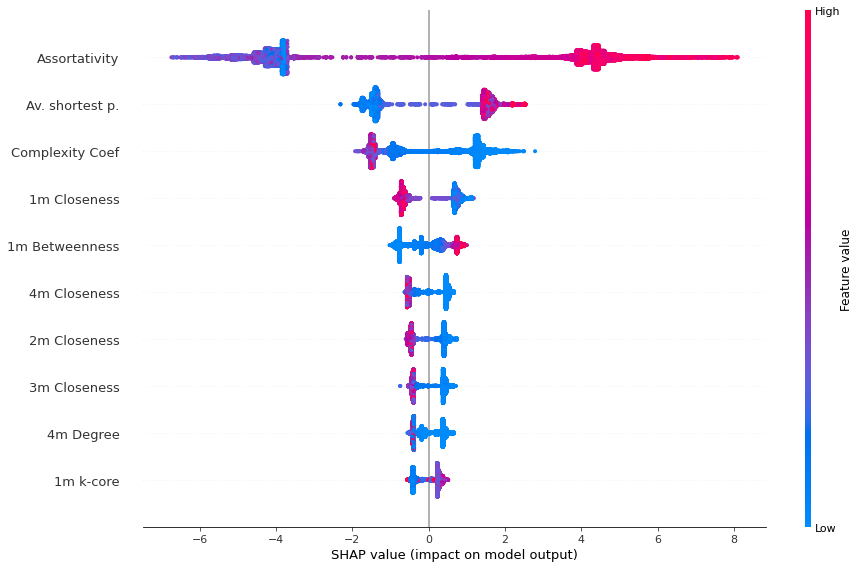

In [47]:
shap.summary_plot(shap_values, Xshap, plot_size=(13,8), show=False, max_display=10)
plt.tight_layout()
plt.savefig('presentation_results/images/shap_reduced.png', dpi=250)
plt.show()

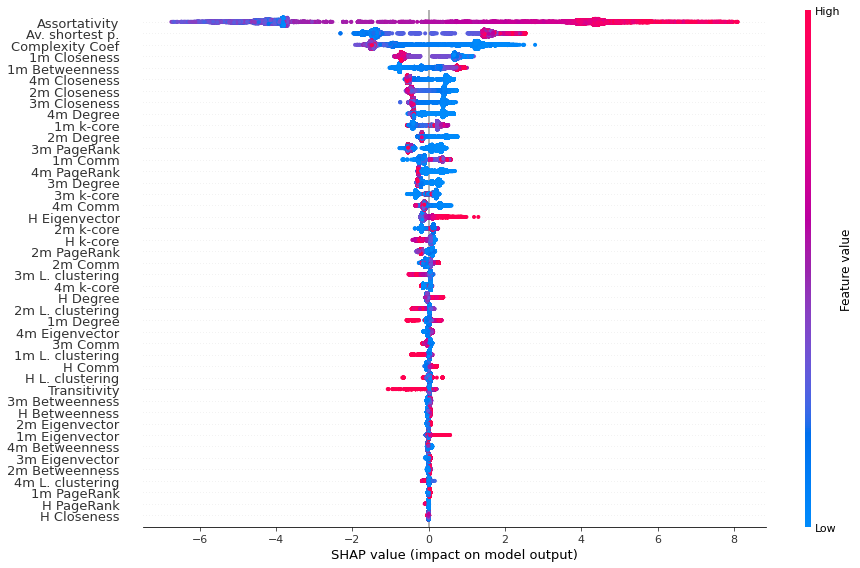

In [50]:
shap.summary_plot(shap_values, Xshap, plot_size=(13,8), show=False, max_display=100)
plt.tight_layout()
plt.savefig('presentation_results/images/shap_complete.png', dpi=250)
plt.show()

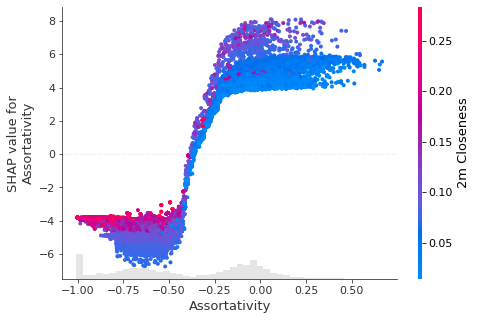

In [51]:
shap.plots.scatter(shap_explanation[:, 'Assortativity'], color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_assortativity.png', dpi=250)

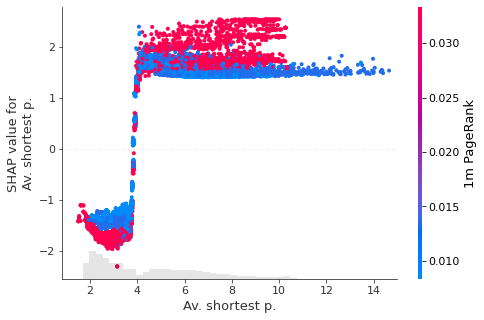

In [52]:
shap.plots.scatter(shap_explanation[:, 'Av. shortest p.'], xmax= 15,color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_av_short_path.png', dpi=250)

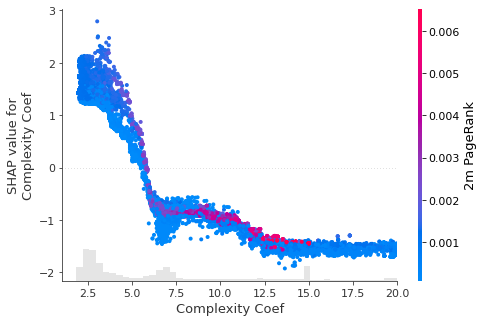

In [53]:
shap.plots.scatter(shap_explanation[:, 'Complexity Coef'], xmax=20, color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_complexity.png', dpi=250)

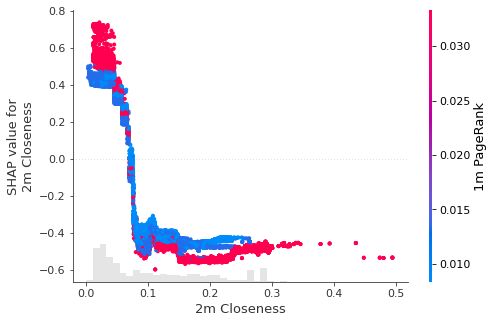

In [54]:
shap.plots.scatter(shap_explanation[:, '2m Closeness'], color=shap_explanation)

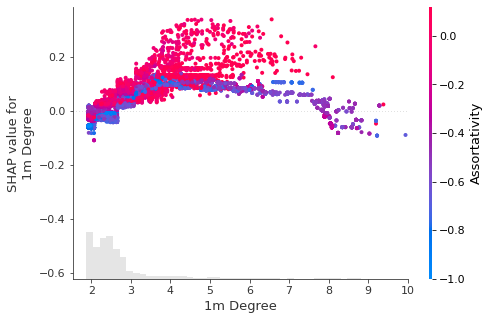

In [55]:
shap.plots.scatter(shap_explanation[:, '1m Degree'], xmax=10, color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_1m_degree.png', dpi=250)

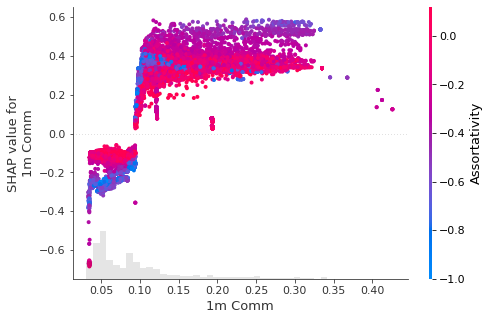

In [56]:
shap.plots.scatter(shap_explanation[:, '1m Comm'], color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_1m_comm.png', dpi=250)

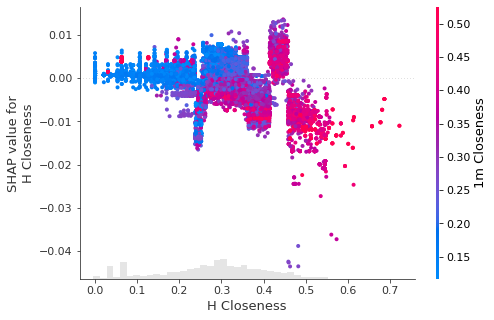

In [59]:
shap.plots.scatter(shap_explanation[:, 'H Closeness'], color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_h_closeness.png', dpi=250)

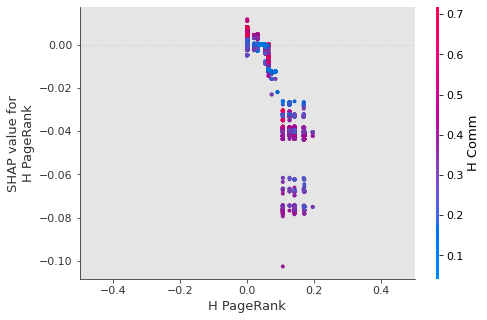

In [60]:
shap.plots.scatter(shap_explanation[:, 'H PageRank'], color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_h_pagerank.png', dpi=250)

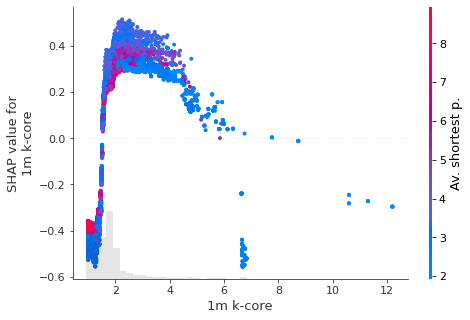

In [61]:
shap.plots.scatter(shap_explanation[:, '1m k-core'], color=shap_explanation, show=False)
plt.savefig('presentation_results/images/shap_1m_k_core.png', dpi=250)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

The same analysis is perfored for RWS and MHRW samples bellow:

In [25]:
data_ba = pd.read_csv('2_multivariate_analysis/data/pca_ba_robust_example.csv')

data_er = pd.read_csv('2_multivariate_analysis/data/pca_er_robust_example2.csv')

data_sw = pd.read_csv('2_multivariate_analysis/data/pca_sw_robust_example.csv')

data_maier = pd.read_csv('2_multivariate_analysis/data/pca_meier_robust_example.csv')

In [26]:
data = pd.concat([data_ba, data_er, data_sw, data_maier], axis=0)

In [27]:
data.shape

(150031, 50)

In [67]:
method0 = 'RWS'
method1 = 'MHRW' 

In [68]:
subpop_data = data[(data['method']==method0) | (data['method']==method1)].copy()

In [69]:
subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

In [70]:
# X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
# X = subpop_data[['Component0', 'Component1', 'Component2']]
X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator'], axis=1)
y = subpop_data['indicator']

In [71]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer, roc_auc_score

In [72]:
def gini_score(expected, predicted, **unused_kwargs) -> float:
    return abs(roc_auc_score(expected, predicted)-0.5)*2.0

In [73]:
X_train_superset, X_test, y_train_superset, y_test = train_test_split(X, y, test_size=0.4, random_state=2112)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_superset, y_train_superset, test_size=0.2, random_state=19)

del X_train_superset
del y_train_superset

In [74]:
train_pool = Pool(X_train, y_train)

In [75]:
model = CatBoostClassifier(
    thread_count=3,
    iterations=2000,
    learning_rate=.015,
    depth=5.0,
    l2_leaf_reg=0.550,
    min_child_samples=10.0,
    grow_policy='SymmetricTree',
    loss_function='Logloss',
    eval_metric='Logloss',
    # eval_metric='AUC:hints=skip_train~false',
    od_type='Iter',
    bootstrap_type='Bayesian',
    auto_class_weights='Balanced'
).fit(
    train_pool,
    early_stopping_rounds=100,
    eval_set=Pool(X_valid, y_valid),
    save_snapshot=False
)

0:	learn: 0.6903910	test: 0.6904325	best: 0.6904325 (0)	total: 19.8ms	remaining: 39.5s
1:	learn: 0.6879357	test: 0.6880725	best: 0.6880725 (1)	total: 35.2ms	remaining: 35.1s
2:	learn: 0.6854591	test: 0.6856998	best: 0.6856998 (2)	total: 51.9ms	remaining: 34.6s
3:	learn: 0.6835117	test: 0.6837628	best: 0.6837628 (3)	total: 66.6ms	remaining: 33.2s
4:	learn: 0.6812024	test: 0.6815720	best: 0.6815720 (4)	total: 86ms	remaining: 34.3s
5:	learn: 0.6790565	test: 0.6794820	best: 0.6794820 (5)	total: 106ms	remaining: 35.1s
6:	learn: 0.6767174	test: 0.6772509	best: 0.6772509 (6)	total: 126ms	remaining: 35.8s
7:	learn: 0.6746395	test: 0.6751705	best: 0.6751705 (7)	total: 145ms	remaining: 36s
8:	learn: 0.6727158	test: 0.6732964	best: 0.6732964 (8)	total: 164ms	remaining: 36.2s
9:	learn: 0.6709873	test: 0.6716624	best: 0.6716624 (9)	total: 183ms	remaining: 36.5s
10:	learn: 0.6689427	test: 0.6696922	best: 0.6696922 (10)	total: 199ms	remaining: 36s
11:	learn: 0.6671019	test: 0.6678696	best: 0.6678696 

In [76]:
y_pred = np.round(model.predict_proba(X_test)[:, 1], 5)

In [77]:
gini_score(y_test, y_pred)

0.4811526827881707

In [78]:
roc_auc_score(y_test, y_pred)

0.7405763413940853

In [79]:
shap.initjs()

In [80]:
Xshap = pd.concat([
    X_test[y_test==0], 
    X_test[y_test==1]  
], axis=0).sample(frac=1)

In [81]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xshap)

In [82]:
shap_explanation = explainer(Xshap)

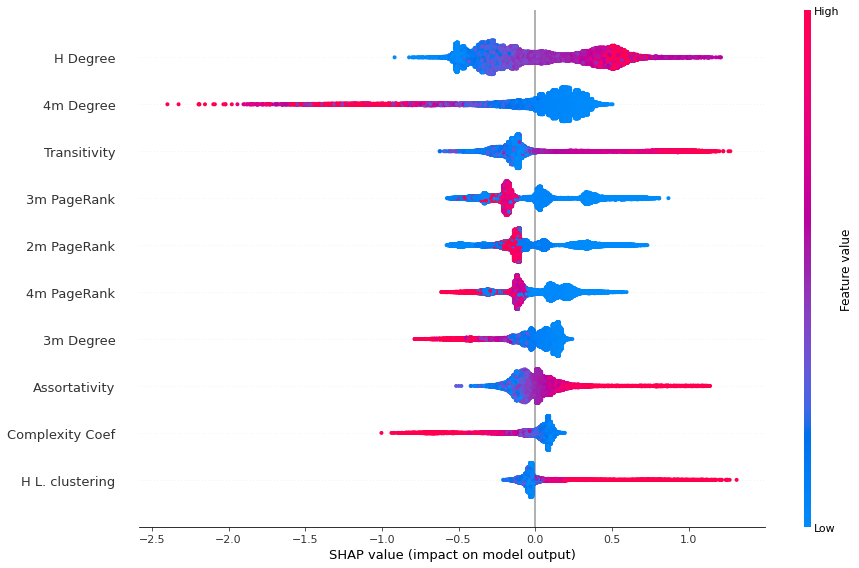

In [83]:
shap.summary_plot(shap_values, Xshap, plot_size=(13,8), show=False, max_display=10)
plt.tight_layout()
# plt.savefig('presentation_results/images/shap_reduced.png', dpi=250)
plt.show()

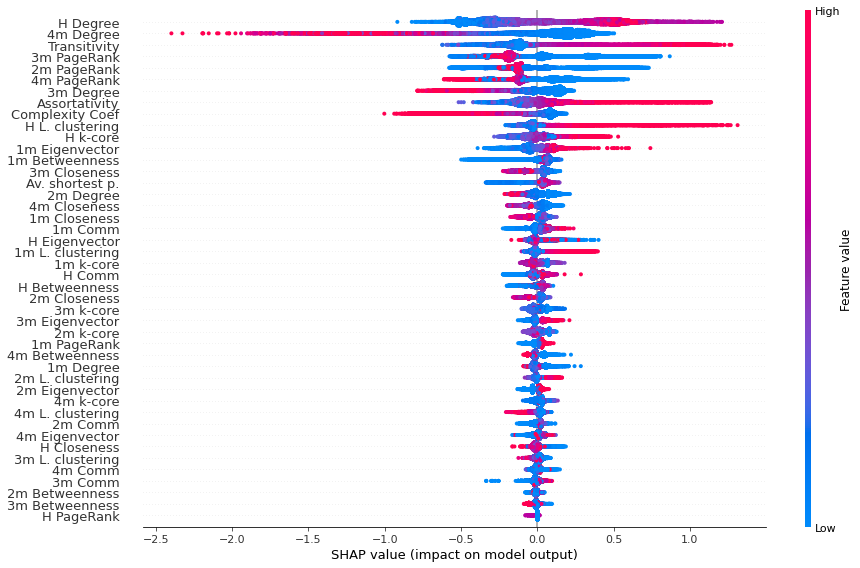

In [84]:
shap.summary_plot(shap_values, Xshap, plot_size=(13,8), show=False, max_display=100)
plt.tight_layout()
# plt.savefig('presentation_results/images/shap_complete.png', dpi=250)
plt.show()

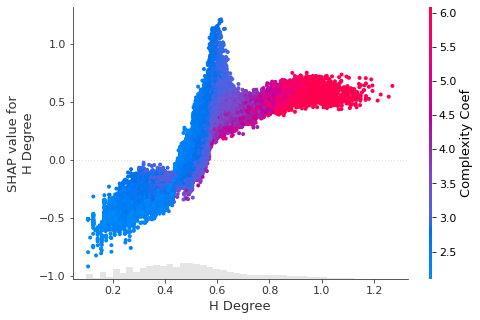

In [85]:
shap.plots.scatter(shap_explanation[:, 'H Degree'], color=shap_explanation)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

And finally, the same analysis is perfored for TR and RWS samples bellow:

In [6]:
data_ba = pd.read_csv('2_multivariate_analysis/data/pca_ba_robust_example.csv')

data_er = pd.read_csv('2_multivariate_analysis/data/pca_er_robust_example2.csv')

data_sw = pd.read_csv('2_multivariate_analysis/data/pca_sw_robust_example.csv')

data_maier = pd.read_csv('2_multivariate_analysis/data/pca_meier_robust_example.csv')

In [7]:
data = pd.concat([data_ba, data_er, data_sw, data_maier], axis=0)

In [8]:
data.shape

(150031, 50)

In [27]:
method0 = 'TR'
method1 = 'RWS' 

In [28]:
subpop_data = data[(data['method']==method0) | (data['method']==method1)].copy()

In [29]:
subpop_data['indicator'] = subpop_data['method'].apply(lambda x: 1 if x==method1 else 0)

In [30]:
# X = subpop_data[['Assortativity', 'Complexity Coef', '1m Degree', '2m Degree', '3m Degree', '4m Degree', 'H Degree']]
# X = subpop_data[['Component0', 'Component1', 'Component2']]
X = subpop_data.drop(['Component0', 'Component1', 'Component2', 'net id', 'method', 'len', 'indicator'], axis=1)
y = subpop_data['indicator']

In [31]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import make_scorer, roc_auc_score

In [32]:
def gini_score(expected, predicted, **unused_kwargs) -> float:
    return abs(roc_auc_score(expected, predicted)-0.5)*2.0

In [33]:
X_train_superset, X_test, y_train_superset, y_test = train_test_split(X, y, test_size=0.4, random_state=2112)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_superset, y_train_superset, test_size=0.2, random_state=19)

del X_train_superset
del y_train_superset

In [34]:
train_pool = Pool(X_train, y_train)

In [35]:
model = CatBoostClassifier(
    thread_count=3,
    iterations=2000,
    learning_rate=.015,
    depth=5.0,
    l2_leaf_reg=0.550,
    min_child_samples=10.0,
    grow_policy='SymmetricTree',
    loss_function='Logloss',
    eval_metric='Logloss',
    # eval_metric='AUC:hints=skip_train~false',
    od_type='Iter',
    bootstrap_type='Bayesian',
    auto_class_weights='Balanced'
).fit(
    train_pool,
    early_stopping_rounds=100,
    eval_set=Pool(X_valid, y_valid),
    save_snapshot=False
)

0:	learn: 0.6472963	test: 0.6471961	best: 0.6471961 (0)	total: 24.2ms	remaining: 48.4s
1:	learn: 0.6047691	test: 0.6047082	best: 0.6047082 (1)	total: 42.6ms	remaining: 42.6s
2:	learn: 0.5639685	test: 0.5640022	best: 0.5640022 (2)	total: 60.5ms	remaining: 40.2s
3:	learn: 0.5289524	test: 0.5291970	best: 0.5291970 (3)	total: 78.3ms	remaining: 39.1s
4:	learn: 0.5017539	test: 0.5020386	best: 0.5020386 (4)	total: 97.5ms	remaining: 38.9s
5:	learn: 0.4661814	test: 0.4665582	best: 0.4665582 (5)	total: 116ms	remaining: 38.6s
6:	learn: 0.4352881	test: 0.4359056	best: 0.4359056 (6)	total: 134ms	remaining: 38.1s
7:	learn: 0.4130219	test: 0.4137407	best: 0.4137407 (7)	total: 150ms	remaining: 37.5s
8:	learn: 0.3836374	test: 0.3845043	best: 0.3845043 (8)	total: 167ms	remaining: 37s
9:	learn: 0.3565467	test: 0.3575247	best: 0.3575247 (9)	total: 185ms	remaining: 36.7s
10:	learn: 0.3366278	test: 0.3375376	best: 0.3375376 (10)	total: 201ms	remaining: 36.4s
11:	learn: 0.3197942	test: 0.3206467	best: 0.3206

In [36]:
y_pred = np.round(model.predict_proba(X_test)[:, 1], 5)

In [37]:
gini_score(y_test, y_pred)

0.999920388868986

In [38]:
roc_auc_score(y_test, y_pred)

0.999960194434493

In [39]:
shap.initjs()

In [40]:
Xshap = pd.concat([
    X_test[y_test==0], 
    X_test[y_test==1]  
], axis=0).sample(frac=1)

In [41]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xshap)

In [42]:
shap_explanation = explainer(Xshap)

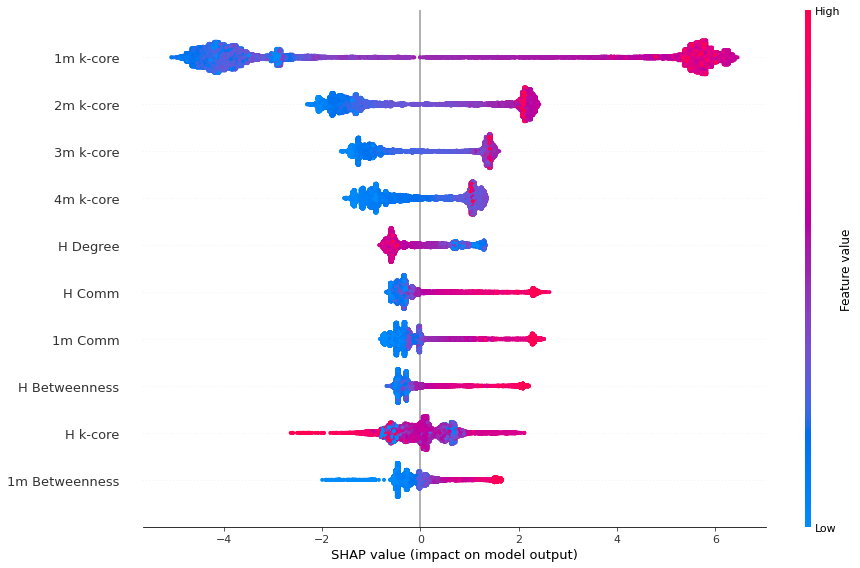

In [43]:
shap.summary_plot(shap_values, Xshap, plot_size=(13,8), show=False, max_display=10)
plt.tight_layout()
# plt.savefig('presentation_results/images/shap_reduced.png', dpi=250)
plt.show()

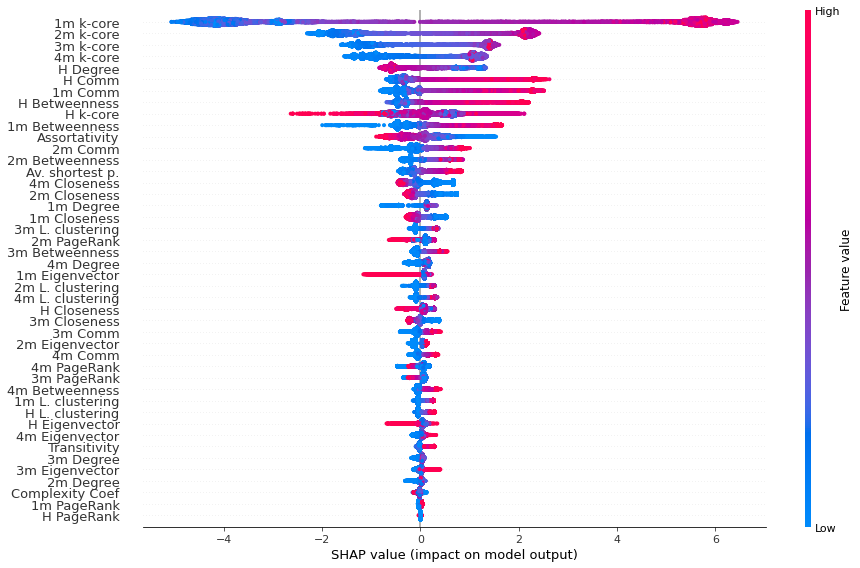

In [44]:
shap.summary_plot(shap_values, Xshap, plot_size=(13,8), show=False, max_display=100)
plt.tight_layout()
# plt.savefig('presentation_results/images/shap_complete.png', dpi=250)
plt.show()

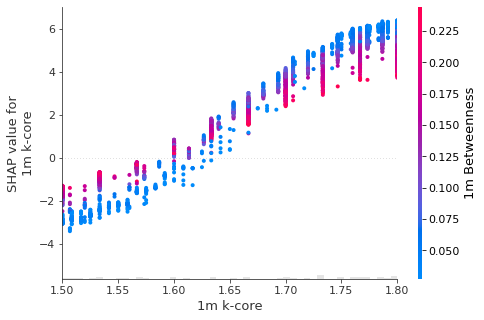

In [54]:
shap.plots.scatter(shap_explanation[:, '1m k-core'], color=shap_explanation, xmax=1.8, xmin=1.5)